Question 1.1-1.5

In [8]:
import pandas as pd
import os

# Helper function to analyze chromosome files
def analyze_chrom_sizes(file_path, species_name):
    df = pd.read_csv(file_path, sep="\t", header=None, names=["chrom", "size"])
    
    total_genome_size = df["size"].sum()
    num_chromosomes = len(df)
    largest_chrom = df.loc[df["size"].idxmax()]
    smallest_chrom = df.loc[df["size"].idxmin()]
    mean_size = df["size"].mean()
    
    return {
        "Species": species_name,
        "Total genome size (bp)": total_genome_size,
        "Number of chromosomes": num_chromosomes,
        "Largest chromosome": largest_chrom["chrom"],
        "Largest size (bp)": largest_chrom["size"],
        "Smallest chromosome": smallest_chrom["chrom"],
        "Smallest size (bp)": smallest_chrom["size"],
        "Mean size (bp)": mean_size
    }

In [10]:
# define file path
files = {
    "E. coli K12": os.path.join("ecoli.chrom.sizes"),
    "Yeast (sacCer3)": os.path.join("yeast.chrom.sizes"),
    "Fruit Fly (dm6)": os.path.join("dm6.chrom.sizes"),
    "Arabidopsis (TAIR10)": os.path.join("TAIR10.chrom.sizes"),
    "Tomato (v4.00)": os.path.join("tomato.chrom.sizes"),
    "Human (hg38)": os.path.join("hg38.chrom.sizes"),
    "Wheat (IWGSC)": os.path.join("wheat.chrom.sizes"),
}

In [11]:
# run analysis 
results = []
for species, path in files.items():
    res = analyze_chrom_sizes(path, species)
    results.append(res)

summary_table = pd.DataFrame(results)
summary_table

,Species,Total genome size (bp),Number of chromosomes,Largest chromosome,Largest size (bp),Smallest chromosome,Smallest size (bp),Mean size (bp)
0,E. coli K12,4639211,1,Ecoli,4639211,Ecoli,4639211,4.639211e+06
1,Yeast (sacCer3),12157105,17,chrIV,1531933,chrM,85779,7.151238e+05
2,Fruit Fly (dm6),137547960,7,chr3R,32079331,chr4,1348131,1.964971e+07
3,Arabidopsis (TAIR10),119146348,5,Chr1,30427671,Chr4,18585056,2.382927e+07
4,Tomato (v4.00),782520033,13,ch01,90863682,ch00,9643250,6.019385e+07
5,Human (hg38),3088269832,24,chr1,248956422,chr21,46709983,1.286779e+08
6,Wheat (IWGSC),14547261565,22,3B,830829764,6D,473592718,6.612392e+08


Question 2.1

To sequence a 1Mbp genome to 3x coverage using 100bp reads, we need to first assume the 100 bp reads can perfectly cover the entire genome, each read follows head-to-tail. Therefore, we would need: 

$$
N = \frac{3 \times 1{,}000{,}000}{100} = 30{,}000
$$

reads to sequence the genome to 3x coverage.

Question 2.2-2.5
helper functions

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Simulator
def simulate_reads(genome_len=1_000_000, read_len=100, target_cov=3, seed=None):
    """
    Simulate genome coverage by randomly placing reads.
    Returns an array of coverage per base.
    """
    if seed is not None:
        np.random.seed(seed)
    
    num_reads = (genome_len * target_cov) // read_len
    coverage_array = np.zeros(genome_len, dtype=int)
    
    # choose random starting positions
    starts = np.random.randint(0, genome_len - read_len + 1, size=num_reads)
    for s in starts:
        coverage_array[s:s+read_len] += 1
    
    return coverage_array, num_reads

# Poisson expectation 
def poisson_expectations(k_vals, lam, genome_len):
    probs = np.zeros_like(k_vals, dtype=float)
    probs[0] = math.exp(-lam)
    for k in range(1, len(k_vals)):
        probs[k] = probs[k-1] * lam / k
    return genome_len * probs

# Normal expectation (continuous pdf, not discretized) 
def normal_expectations(k_vals, mu, sigma, genome_len):
    coeff = 1.0 / (sigma * math.sqrt(2 * math.pi))
    density = coeff * np.exp(-0.5 * ((k_vals - mu) / sigma) ** 2)
    return genome_len * density

# Plotting + reporting 
def plot_with_overlays(cov_array, lam, mu, sigma, title="Coverage histogram"):
    genome_len = len(cov_array)
    counts = np.bincount(cov_array)
    k_vals = np.arange(len(counts))

    # expectations
    pois_counts = poisson_expectations(k_vals, lam, genome_len)
    norm_counts = normal_expectations(k_vals, mu, sigma, genome_len)

    # plot
    plt.figure(figsize=(8,5))
    plt.bar(k_vals, counts, alpha=0.5, label="Observed (simulation)")
    plt.plot(k_vals, pois_counts, label=f"Poisson λ={lam}")
    plt.plot(k_vals, norm_counts, label=f"Normal μ={mu}, σ={sigma:.2f}")
    plt.yscale("log")  # makes tails visible
    plt.xlabel("Coverage")
    plt.ylabel("Number of positions")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return counts

def report_zero_coverage(counts, lam, genome_len, mu=None, sigma=None):
    observed_zero = counts[0] if len(counts) > 0 else 0
    expected_zero = genome_len * math.exp(-lam)
    print(f"Zero coverage bases: {observed_zero:,} "
          f"({observed_zero/genome_len:.2%})")
    print(f"Poisson expectation: {expected_zero:.0f} "
          f"({math.exp(-lam):.2%})")
    
    if mu is not None and sigma is not None:
        # Normal approximation: probability of coverage = 0
        # approximated by P(-0.5 < X < 0.5)
        from math import erf, sqrt
        def Phi(x):  # Normal CDF
            return 0.5 * (1 + erf((x - mu) / (sigma * sqrt(2))))
        prob_zero_normal = Phi(0.5) - Phi(-0.5)
        expected_zero_normal = genome_len * prob_zero_normal
        print(f"Normal expectation: {expected_zero_normal:.0f} "
              f"({prob_zero_normal:.2%})")

Question 2.2 (3x coverage)

Number of reads placed: 30000


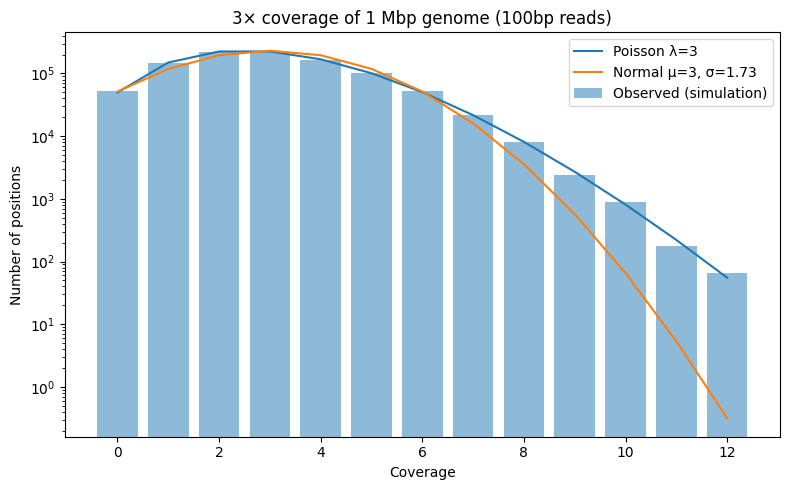

Zero coverage bases: 51,854 (5.19%)
Poisson expectation: 49787 (4.98%)
Normal expectation: 52803 (5.28%)


In [5]:
cov3, nreads3 = simulate_reads(genome_len=1_000_000, read_len=100, target_cov=3, seed=123)
print(f"Number of reads placed: {nreads3}")
counts3 = plot_with_overlays(cov3, lam=3, mu=3, sigma=math.sqrt(3),
                             title="3× coverage of 1 Mbp genome (100bp reads)")
report_zero_coverage(counts3, lam=3, genome_len=1_000_000, mu=3, sigma=math.sqrt(3))


Question 2.3

According to the figure generated, 51854 observed genome has not been sequenced. It matches the Poisson expectations pretty well as the Poisson expects around 49787 ogenome unsequenced, which is very close to the observation. The normal distribution fits the data pretty well at the center (max counts of the distribution) but not so well for in the tails of the distribution. 

Question 2.4 (10x coverage)

Number of reads placed: 100000


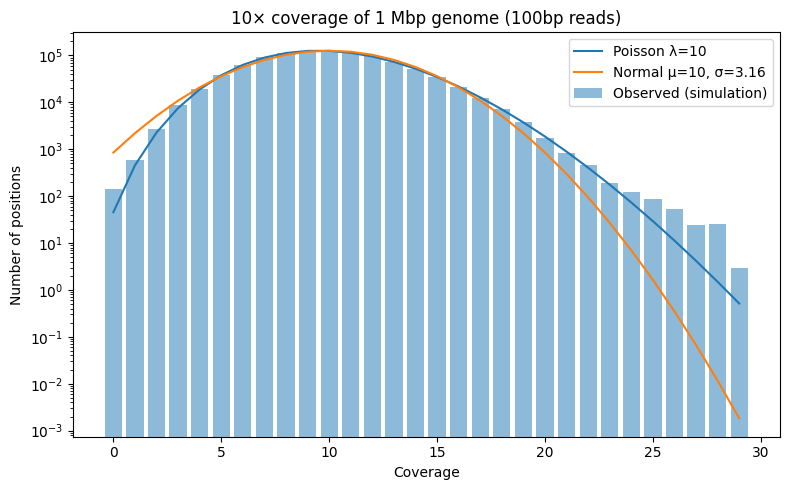

Zero coverage bases: 142 (0.01%)
Poisson expectation: 45 (0.00%)
Normal expectation: 882 (0.09%)


In [8]:
cov10, nreads10 = simulate_reads(genome_len=1_000_000, read_len=100, target_cov=10, seed=123)
print(f"Number of reads placed: {nreads10}")
counts10 = plot_with_overlays(cov10, lam=10, mu=10, sigma=math.sqrt(10),
                              title="10× coverage of 1 Mbp genome (100bp reads)")
report_zero_coverage(counts10, lam=10, genome_len=1_000_000, mu=10, sigma=math.sqrt(10))


According to the figure generated, the histogram becomes more symmetric. The Poisson distribution still fits well, but it's less accurate in estimating the zero coverage bases than it previously did. The normal distribution starts to approximate the center more decently, but its estimates on the tails are still less fitted than Poisson. 

Question 2.5 (30x coverage)

Number of reads placed: 300000


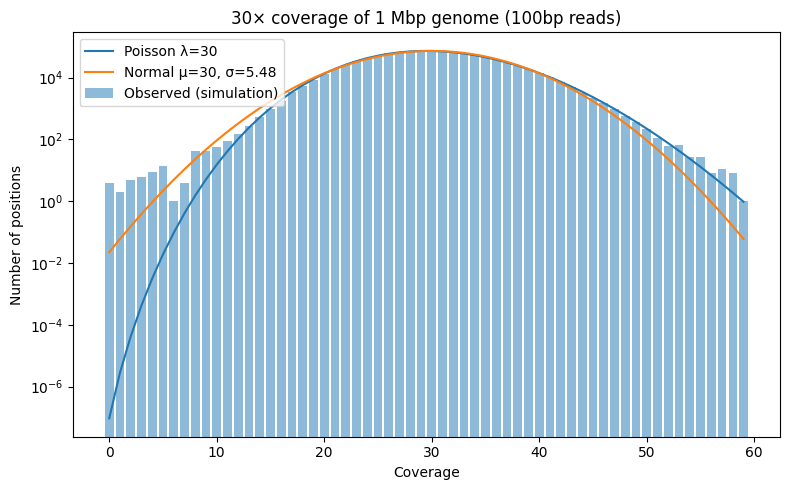

Zero coverage bases: 4 (0.00%)
Poisson expectation: 0 (0.00%)
Normal expectation: 0 (0.00%)


In [9]:
cov30, nreads30 = simulate_reads(genome_len=1_000_000, read_len=100, target_cov=30, seed=123)
print(f"Number of reads placed: {nreads30}")
counts30 = plot_with_overlays(cov30, lam=30, mu=30, sigma=math.sqrt(30),
                              title="30× coverage of 1 Mbp genome (100bp reads)")
report_zero_coverage(counts30, lam=30, genome_len=1_000_000, mu=30, sigma=math.sqrt(30))



According to the figure generated, the histogram has become more like normal. Now, the normal distribution fits the histogram better than the Poisson distribution, and estimates the genome with zero coverage more accurately. 

Question 3

In [1]:
import gzip
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import numpy as np

# file path (adjust if needed)
fasta_file = "chr22.fa.gz"

# read sequence into one big string
def read_fasta(filename, limit=None):
    seq_parts = []
    with gzip.open(filename, "rt") as f:  # read in text mode
        for line in f:
            if line.startswith(">"):  # skip header
                continue
            seq_parts.append(line.strip())
            if limit and sum(len(s) for s in seq_parts) >= limit:
                break
    return "".join(seq_parts)

# Example: read entire chromosome or first 20 Mbp if memory an issue
genome = read_fasta(fasta_file)   # full chromosome
print("Genome length:", len(genome))

Genome length: 50818468


Question 3.1

In [2]:
# convert to uppercase and replace invalid characters with 'N'
genome_upper = "".join([b if b in "ACGTN" else "N" for b in genome.upper()])

# count bases
base_counts = Counter(genome_upper)
print("Base composition (A,C,G,T,N):", base_counts)

Base composition (A,C,G,T,N): Counter({'N': 11658691, 'A': 10382214, 'T': 10370725, 'G': 9246186, 'C': 9160652})


Question 3.2

In [4]:
k = 19

# replace non-ACGT with 'A' (so N→A)
genome_clean = "".join([b if b in "ACGT" else "A" for b in genome_upper])

kmer_counts = Counter()
for i in range(len(genome_clean) - k + 1):
    kmer = genome_clean[i:i+k]
    kmer_counts[kmer] += 1

print("Total kmers (G-k+1):", len(genome_clean) - k + 1)
print("Distinct kmers:", len(kmer_counts))

freq_of_freq = Counter(kmer_counts.values())  # maps frequency → how many kmers have that frequency

# Show first 20 frequencies (1–20)
print("Frequency spectrum (1–20):")
for i in range(1, 21):
    print(i, freq_of_freq.get(i, 0))

# Save spectrum up to 1000 for plotting
spectrum = {f: c for f, c in freq_of_freq.items() if f <= 1000}

Total kmers (G-k+1): 50818450
Distinct kmers: 31057533
Frequency spectrum (1–20):
1 29426883
2 989900
3 264955
4 123280
5 57189
6 32993
7 23782
8 17025
9 13269
10 10841
11 9079
12 7525
13 6495
14 5724
15 4830
16 4388
17 3979
18 3462
19 3095
20 2806


Question 3.3

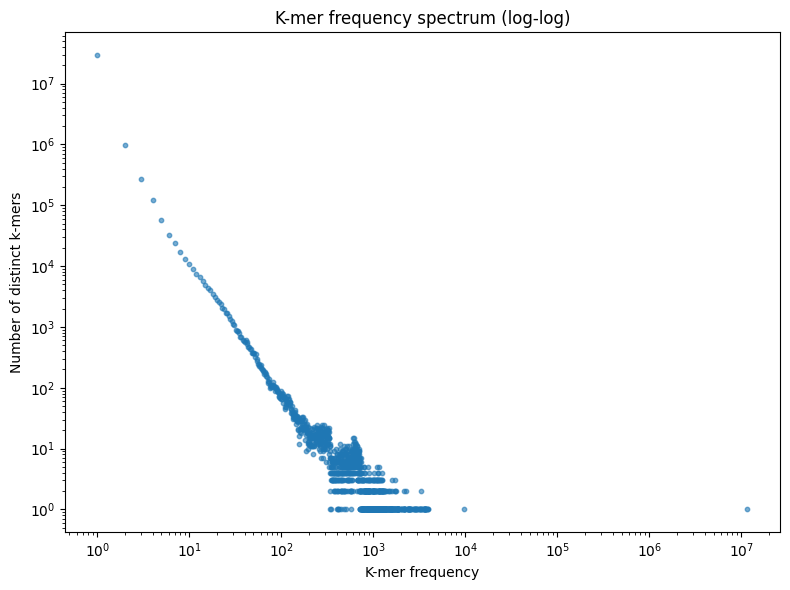

In [5]:
x = list(freq_of_freq.keys())
y = list(freq_of_freq.values())

plt.figure(figsize=(8,6))
plt.scatter(x, y, s=10, alpha=0.6)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("K-mer frequency")
plt.ylabel("Number of distinct k-mers")
plt.title("K-mer frequency spectrum (log-log)")
plt.tight_layout()
plt.show()

# the one in the very right: All As because we replace the sequence of all Ns w all As (recall that sequence files usually start w many Ns)

Question 3.4

In [6]:
total_kmers = len(genome_clean) - k + 1

# (a) unique kmers (frequency = 1)
unique_count = freq_of_freq[1]
unique_percent = (unique_count / total_kmers) * 100

# (b) repetitive kmers = occur more than once (count each instance!)
repetitive_instances = sum(freq * c for freq, c in freq_of_freq.items() if freq > 1)
repetitive_percent = (repetitive_instances / total_kmers) * 100

# (c) kmers that occur >1000 times (count each instance!)
over1000_instances = sum(freq * c for freq, c in freq_of_freq.items() if freq > 1000)
over1000_percent = (over1000_instances / total_kmers) * 100

print(f"Unique % (occurs once): {unique_percent:.2f}%")
print(f"Repetitive % (>1 time): {repetitive_percent:.2f}%")
print(f">1000 occurrence %: {over1000_percent:.2f}%")

Unique % (occurs once): 57.91%
Repetitive % (>1 time): 42.09%
>1000 occurrence %: 24.44%


Question 4

Response in Piazza: https://piazza.com/class/meogfdbmu7x7hf/post/11_f9